# Deep Learning 2025/12/10：強化學習基礎與實作
- 教學目標：
  - 了解強化學習 (Reinforcement Learning, RL) 的核心概念 (State, Action, Reward)
  - 掌握策略梯度 (Policy Gradient) 的數學原理與程式實作
  - 實作 RL 模型解決 CartPole (木棒台車平衡) 控制問題
- 函式庫：
  - [Gymnasium](https://gymnasium.farama.org/) (環境模擬)
  - [PyTorch](https://pytorch.org/) (神經網路)
  - `imageio`, `pyvirtualdisplay` (Colab 錄影視覺化工具)
- 實作模型：Policy Gradient (REINFORCE) on CartPole-v1

In [8]:
# 0-1. 安裝虛擬螢幕與繪圖套件 (執行完後建議 "Restart Runtime" 但通常不重啟也能跑)

!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gymnasium pyvirtualdisplay imageio imageio-ffmpeg > /dev/null 2>&1

In [10]:
# 0-2. 導入所需套件

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import imageio
from pyvirtualdisplay import Display
from IPython.display import Video, display

In [11]:
# 1. 準備工作：啟動虛擬螢幕與定義模型

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [12]:
# 2. 定義策略網路 (Policy Network)

policy = nn.Sequential(
    nn.Linear(4, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
env = gym.make('CartPole-v1')

In [13]:
# 3. 定義錄影函數

def record_video(filename, policy_net, max_steps=500):
    test_env = gym.make('CartPole-v1', render_mode="rgb_array")
    state, _ = test_env.reset()
    frames = []
    done = False
    steps = 0
    while not done and steps < max_steps:
        frames.append(test_env.render())
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            # 這裡選機率最大的動作
            action = torch.argmax(policy_net(state_tensor)).item()
        state, _, done, _, _ = test_env.step(action)
        steps += 1
    test_env.close()
    imageio.mimsave(filename, frames, fps=30)
    print(f"影片 {filename} 已儲存 (堅持了 {steps} 步)")

In [14]:
# 4. 訓練前錄影 (看模型訓練前的狀態)

print(">>> 階段一：錄製訓練前的笨笨 AI...")
record_video('before_training.mp4', policy)
display(
    Video(
        "before_training.mp4",
        embed=True,
        width=500,
        html_attributes="loop autoplay",
    )
)

>>> 階段一：錄製訓練前的笨笨 AI...
影片 before_training.mp4 已儲存 (堅持了 10 步)


In [15]:
# 5. 開始訓練

print("\n>>> 階段二：開始特訓 (約需 20-30 秒)...")
reward_history = []
for i in range(500): # 訓練 500 回合
    state, _ = env.reset()
    log_probs = []
    rewards = []
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = policy(state)
        m = Categorical(probs)
        action = m.sample() # 訓練時要有隨機性
        next_state, reward, done, _, _ = env.step(action.item())
        log_probs.append(m.log_prob(action))
        rewards.append(reward)
        state = next_state

    reward_history.append(sum(rewards))

    # Policy Gradient 更新
    loss = 0
    G = 0
    for lp, r in zip(reversed(log_probs), reversed(rewards)):
        G = r + 0.99 * G
        loss -= lp * G
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Episode {i}, 分數: {sum(rewards)}")


>>> 階段二：開始特訓 (約需 20-30 秒)...
Episode 0, 分數: 13.0
Episode 100, 分數: 51.0
Episode 200, 分數: 148.0
Episode 300, 分數: 204.0
Episode 400, 分數: 295.0


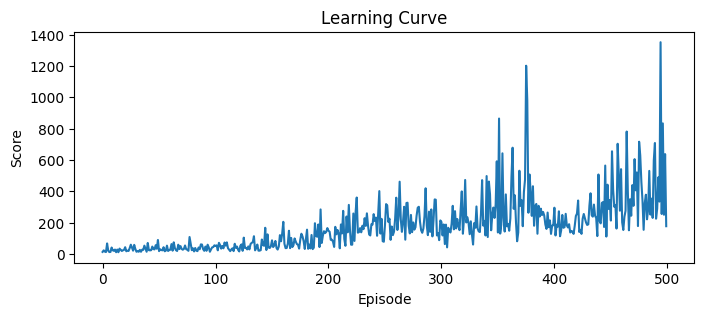

In [16]:
# 6. 畫出學習曲線

plt.figure(figsize=(8, 3))
plt.plot(reward_history)
plt.title("Learning Curve")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()

In [17]:
# 7. 訓練後錄影 (展示學會平衡的樣子)

print("\n>>> 階段三：錄製訓練後的天才 AI...")
record_video('after_training.mp4', policy)
display(
    Video(
        "after_training.mp4",
        embed=True,
        width=500,
        html_attributes="loop autoplay",
    )
)


>>> 階段三：錄製訓練後的天才 AI...


影片 after_training.mp4 已儲存 (堅持了 500 步)
